Python 程序在运行的时候，需要在内存中开辟出一块空间，用于存放运行时产生的临时变量；计算完成后，再将结果输出到永久性存储器中。如果数据量过大，内存空间管理不善就很容易出现 OOM（out of memory），俗称爆内存，程序可能被操作系统中止。

对于服务器这种设计为永不中断的系统来说，内存管理则显得更为重要，不然很容易引发内存泄漏。

**内存泄漏**<br/>程序本身没有设计好，导致程序未能释放已不再使用的内存。<br/>内存泄漏也不是指你的内存在物理上消失了，而是意味着代码在分配了某段内存后，因为设计错误，失去了对这段内存的控制，从而造成了内存的浪费。

## 计数引用

变量都是对象的一个指针，当对象的引用次数为0的时候，说明这个对象永不可达，需要被回收。

In [33]:
import os
import psutil
 
# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    show_memory_info('after a created')
 
func()
show_memory_info('finished')

initial memory used: 472.24609375 MB
after a created memory used: 838.59375 MB
finished memory used: 472.24609375 MB


调用函数 func()，在列表 a 被创建之后，内存占用迅速增加，而在函数调用结束后，内存则返回正常。因为函数内部声明的列表 a 是局部变量，在函数返回后，局部变量的引用会注销掉；此时，列表 a 所指代对象的引用数为 0，Python 便会执行垃圾回收，因此之前占用的大量内存就又回来了。

In [38]:
import os
import psutil
 
# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))
def func():
    show_memory_info('initial')
    global a
    a = [i for i in range(10000000)]
    show_memory_info('after a created')
func()
show_memory_info('finished')

initial memory used: 474.33984375 MB
after a created memory used: 841.3125 MB
finished memory used: 841.3125 MB


将 a 声明为全局变量。那么，即使函数返回后，列表的引用依然存在，于是对象就不会被垃圾回收掉，依然占用大量内存。

In [37]:
import os
import psutil
# 显示当前 python 程序占用的内存大小
def show_memory_info(hint):
    pid = os.getpid()
    p = psutil.Process(pid)
    info = p.memory_full_info()
    memory = info.uss / 1024. / 1024
    print('{} memory used: {} MB'.format(hint, memory))
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    show_memory_info('after a created')
    return a
func()
show_memory_info('finished')

initial memory used: 474.3359375 MB
after a created memory used: 841.65625 MB
finished memory used: 474.3359375 MB


如果我们把生成的列表返回，然后在主程序中接收，那么引用依然存在，垃圾回收就不会被触发，大量内存仍然被占用着

python内部的引用计数机制<br/>sys.getrefcount()可以查看一个变量的引用次数，getrefcount本身也会引入一次计数。<br/>在函数调用发生的时候，会产生额外的两次引用，一次来自函数栈，另一个是函数参数。

In [44]:
import sys
a = []
# 两次引用，一次来自 a，一次来自 getrefcount
print(sys.getrefcount(a))

def func(a):
    # 四次引用，a，python 的函数调用栈，函数参数，和 getrefcount
    print(sys.getrefcount(a))
func(a)

# 两次引用，一次来自 a，一次来自 getrefcount，函数 func 调用已经不存在
print(sys.getrefcount(a))

2
4
2


In [46]:
#case
import sys
a = []
 
print(sys.getrefcount(a)) # 两次,一次来自a，一次来自getrefcount本身
 
b = a
 
print(sys.getrefcount(a)) # 三次，一次来自a，一次来自b的引用，一次来自getrefcount本身
 
c = b
d = b
e = c
f = e
g = d
 
print(sys.getrefcount(a)) # 八次，所有的变量都是指向同一个对象a

2
3
8


Pyhton可以自动引用释放，也可以手动释放<br/>通过del a 删除一个对象，然后强制调用gc.collect(),即可手动启动垃圾回收

In [52]:
import gc
 
show_memory_info('initial')
 
a = [i for i in range(10000000)]
 
show_memory_info('after a created')
 
del a
gc.collect() #清除内存
 
show_memory_info('finish')
print(a)

initial memory used: 91.46875 MB
after a created memory used: 456.4140625 MB
finish memory used: 92.1015625 MB


NameError: name 'a' is not defined

## 循环引用

In [66]:
# import gc
def func():
    show_memory_info('initial')
    a = [i for i in range(10000000)]
    b = [i for i in range(10000000)]
    show_memory_info('after a, b created')
    a.append(b)
    b.append(a)
 
func()
# gc.collect()
show_memory_info('finished')

initial memory used: 3904.98046875 MB
after a, b created memory used: 2333.73046875 MB
finished memory used: 38.12890625 MB


a，b互相引用，作为局部变量，函数调用之后，依然存在内存占用，因为他们互相引用，导致他们的引用次数都不为0，导致所占的内存空间越来越大，最终撑爆服务器。

**大型工程复杂的情况下，引用环导致难以发现互相引用**<br/>方法1：<br/>显示调用gc.collect(),显示启动垃圾回收<br/>

### 循环引用的自动垃圾回收

python使用标记清除算法和分代收集，启用针对循环引用的自动垃圾回收。

<mark>**标记清除算法：**我们先用图论来理解不可达的概念。对于一个有向图，如果从一个节点出发进行遍历，并标记其经过的所有节点；那么，在遍历结束后，所有没有被标记的节点，我们就称之为不可达节点。显而易见，这些节点的存在是没有任何意义的，自然的，我们就需要对它们进行垃圾回收。
    当然，每次都遍历全图，对于 Python 而言是一种巨大的性能浪费。所以，在 Python 的垃圾回收实现中，mark-sweep 使用双向链表维护了一个数据结构，并且只考虑容器类的对象（只有容器类对象才有可能产生循环引用）。</mark>

<mark>**分代收集算法：**Python 将所有对象分为三代。刚刚创立的对象是第 0 代；经过一次垃圾回收后，依然存在的对象，便会依次从上一代挪到下一代。而每一代启动自动垃圾回收的阈值，则是可以单独指定的。当垃圾回收器中新增对象减去删除对象达到相应的阈值时，就会对这一代对象启动垃圾回收。
事实上，分代收集基于的思想是，新生的对象更有可能被垃圾回收，而存活更久的对象也有更高的概率继续存活。因此，通过这种做法，可以节约不少计算量，从而提高 Python 的性能。</mark>

**引用次数为 0 是垃圾回收启动的充要条件吗？还有没有其他可能性呢？**引用计数是其中最简单的实现，引用计数并非充要条件，它只能算作充分非必要条件；其他的可能性，我们所讲的循环引用正是其中一种。

## 调试内存泄漏
origin:自动回收机制不是万能的，仍然会导致内存泄漏，并且影响性能

objgraph（可视化引用关系包，主要使用两个函数：<br/>show_refs()-生成清晰的关系引用图）<br/>show_backrefs()--生成关系引用图<br/><mark>**[objgraph](https://mg.pov.lt/objgraph/)**</mark>

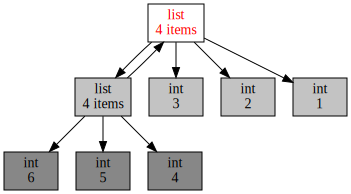

In [1]:
import objgraph
a=[1,2,3]
b=[4,5,6]
a.append(b)
b.append(a)
objgraph.show_refs([a])

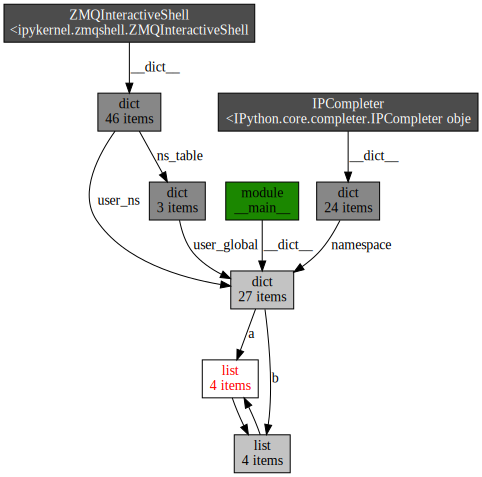

In [2]:
import objgraph
a=[1,2,3]
b=[4,5,6]
a.append(b)
b.append(a)
objgraph.show_backrefs([a])


dict                       1087
tuple                      56
method                     20
list                       13
SignalDict                 10
weakref                    6
coroutine                  5
builtin_function_or_method 4
IncrementalDecoder         1
Del                        1


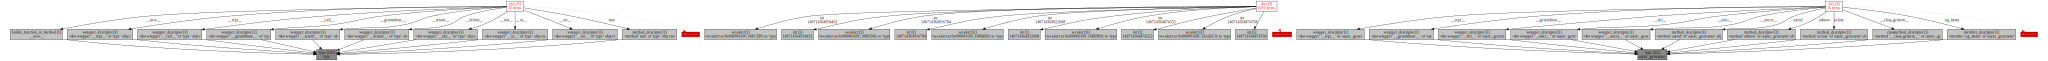

In [5]:
import objgraph
roots = objgraph.get_leaking_objects()
len(roots) 
objgraph.show_most_common_types(objects=roots)
objgraph.show_refs(roots[:3], refcounts=True)